In [187]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd

In [188]:
%run -i columns.py
%run -i helper_functions.py

In [189]:
df = pd.read_csv('tmp/developing_countries.csv')
df.head()

,Country,Country code,Year,Happiness rank,Happiness score,GDP per capita,Social support,Life expectancy,Freedom,Perceptions of corruption,...,Employment in industry (% of total employment) (modeled ILO estimate),Employment in services (% of total employment) (modeled ILO estimate),Forest area (% of land area),Individuals using the Internet (% of population),"Industry (including construction), value added per worker (constant 2010 US$)","Manufacturing, value added (% of GDP)",Medium and high-tech industry (% manufacturing value added),"Railways, goods transported (million ton-km)","Railways, passengers carried (million passenger-km)",Urban population (% of total)
0,Afghanistan,AFG,2015,153,3.575,0.319820,0.302850,0.303350,0.23414,0.097190,...,17.646999,43.674999,2.067825,8.260000,2079.555916,11.420006,9.507434,NaN,NaN,24.803
1,Afghanistan,AFG,2016,154,3.360,0.382270,0.110370,0.173440,0.16430,0.071120,...,17.424999,43.756001,2.067825,10.595726,1999.566153,11.370465,NaN,NaN,NaN,25.020
2,Afghanistan,AFG,2017,141,3.794,0.401477,0.581543,0.180747,0.10618,0.061158,...,17.457001,43.768002,NaN,11.447688,1923.393447,11.102526,NaN,NaN,NaN,25.250
3,Afghanistan,AFG,2018,145,3.632,0.332000,0.537000,0.255000,0.08500,0.036000,...,17.596001,43.816002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Albania,ALB,2015,95,4.959,0.878670,0.804340,0.813250,0.35733,0.064130,...,18.617001,40.020000,28.156934,63.252933,13648.254549,5.671519,6.690696,NaN,NaN,57.434


In [190]:
threshold = 0.6
df_thresh = df.dropna(axis=1, thresh=int(df.shape[0] * threshold))
df_impute = df_thresh.fillna(df_thresh.mean())
df_impute.describe()

,Year,Happiness rank,Happiness score,GDP per capita,Social support,Life expectancy,Freedom,Perceptions of corruption,Generosity,Dystopia residual,"Agriculture, forestry, and fishing, value added per worker (constant 2010 US$)","Air transport, passengers carried","Commercial bank branches (per 100,000 adults)",Employment in agriculture (% of total employment) (modeled ILO estimate),Employment in industry (% of total employment) (modeled ILO estimate),Employment in services (% of total employment) (modeled ILO estimate),Individuals using the Internet (% of population),"Industry (including construction), value added per worker (constant 2010 US$)","Manufacturing, value added (% of GDP)",Urban population (% of total)
count,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,4.570000e+02,4.570000e+02,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000
mean,2016.494530,92.221007,5.022313,0.795687,0.974366,0.512896,0.389140,0.104963,0.214298,2.030955,2.076123e+04,1.814317e+07,13.890841,31.216241,19.793201,48.990571,42.805461,23036.702831,12.666669,55.169177
std,1.118266,39.978960,0.968432,0.365876,0.323990,0.213048,0.150710,0.082750,0.120375,0.585681,1.515434e+05,4.409611e+07,9.118862,21.638516,8.503950,15.875213,21.451886,25886.912377,4.922361,18.276113
min,2015.000000,12.000000,2.693000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001990,0.291000,1.836964e+02,8.990000e+02,0.454000,0.058000,2.086000,5.957000,1.880000,639.511832,1.768629,12.078000
25%,2015.000000,59.000000,4.308000,0.493000,0.777110,0.345780,0.288516,0.054000,0.134000,1.683024,1.852477e+03,1.285642e+06,8.577994,13.104000,13.222000,38.425999,25.664768,9499.450371,10.818186,45.862000
50%,2016.000000,94.000000,5.082000,0.860860,1.003187,0.579000,0.406720,0.085460,0.200000,1.980000,6.568982e+03,1.328510e+07,13.890841,28.452999,19.929001,50.950001,42.805461,23036.702831,12.666669,55.169177
75%,2017.000000,127.000000,5.822000,1.061660,1.226680,0.678060,0.499000,0.128000,0.264750,2.393740,2.076123e+04,1.814317e+07,14.056147,44.521999,25.368999,61.146000,57.272244,23036.702831,13.731697,65.850000
max,2018.000000,158.000000,7.226000,1.870766,1.584000,0.965380,0.724000,0.551910,0.838075,3.837720,2.893900e+06,5.512345e+08,70.561644,91.957001,54.555000,77.537003,97.999989,180220.430997,38.334660,100.000000


## Using sgd data to predict wh data

In [191]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_impute, test_size=0.2)

In [192]:
def split_X_Y(df: pd.DataFrame):
    cols = set(df.columns)
    sgd_cols = set(URBANIZATION_INDICATORS + ANTI_URBANIZATION_INDICATORS)
    mutual = cols.intersection(sgd_cols)
    sgd = df[list(mutual)]

    wh_cols = list(cols - sgd_cols)
    wh = df[wh_cols].drop(['Country', 'Happiness rank', 'Happiness score', 'Country code', 'Year'], axis=1)

    return sgd, wh

In [193]:
from sklearn import preprocessing
def norm_transform_gen(data: np.ndarray):
    scaler = preprocessing.MinMaxScaler().fit(data)
    # scaler = preprocessing.StandardScaler().fit(data)
    return scaler

In [194]:
X, Y = split_X_Y(train)

In [195]:
fpnn_input_columns = X.columns
# X

In [196]:
# Y

In [197]:
X_scaler = norm_transform_gen(X.to_numpy())
Y_scaler = norm_transform_gen(Y.to_numpy())
X_scaled = X_scaler.transform(X.to_numpy())
Y_scaled = Y_scaler.transform(Y.to_numpy())

In [198]:
class FeaturePredictNN(nn.Module):
    def __init__(self, in_features, out_features, hidden_size=20) -> None:
        super().__init__() 
        self.linear1 = nn.Linear(in_features=in_features, out_features=hidden_size)
        self.sig1 = nn.Sigmoid()
        self.linear2 = nn.Linear(in_features=hidden_size, out_features=out_features)
    
    def forward(self, x):
        hidden = self.sig1(self.linear1(x))
        out = self.linear2(hidden)
        return out
        

In [199]:
# data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X = torch.Tensor(X_scaled).to(device)
Y = torch.Tensor(Y_scaled).to(device)

X_test, Y_test = split_X_Y(test)
X_test = X_scaler.transform(X_test.to_numpy())
Y_test = Y_scaler.transform(Y_test.to_numpy())
X_test = torch.Tensor(X_test).to(device)
Y_test = torch.Tensor(Y_test).to(device)

In [200]:
import os
import matplotlib.pyplot as plt
model = FeaturePredictNN(10, 7).to(device)
if not os.path.exists('weights/fpnn.pt'):
    # training 
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    epoches = 200
    mse_loss = nn.MSELoss()

    losses = []
    test_losses = []
    ## plot losses
    plt.plot(losses)
    plt.plot(test_losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['train loss', 'test loss'])
    for epoch in range(1, epoches+1):
        inputs = X
        targets = Y

        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        test_outputs = model(X_test)
        test_loss = mse_loss(test_outputs, Y_test)
        test_losses.append(test_loss.item())

        losses.append(loss.item())

        if epoch % (epoches//10) == 0:
            print(f"loss: {loss.item()}") 

    torch.save(model.state_dict(), 'weights/fpnn.pt')
else:
    model.load_state_dict(torch.load('weights/fpnn.pt'))
    model.eval()

fpnn = model

In [201]:
## produce graphs
X_max = X_scaler.data_max_.copy()
X_min = X_scaler.data_min_.copy()

X_end = X_max.copy()
tmp = X_min.copy()
tmp[1:] = 0

X_start = X_end - tmp

X_original = np.linspace(X_start, X_end, 50)
X_scaled = X_scaler.transform(X_original)

y_out = model(torch.Tensor(X_scaled).to(device))

X_plot = X_original
y_plot = Y_scaler.transform(y_out.cpu().detach().numpy())

In [202]:
X, Y = split_X_Y(train)
X_columns = X.columns
y_columns = Y.columns

In [203]:
from math import ceil
def one2many(X, Y, X_scaler=X_scaler, Y_scaler=Y_scaler):
    # for each factors in sgd data, there will be two values in side in array form
    # eg:
    # res = [[X_plot, Y_plot], ..., [X_plot, Y_plot]]
    res = []

    X_max = X_scaler.data_max_.copy()
    X_min = X_scaler.data_min_.copy()

    for i in range(X.shape[1]):
        X_end = X_max.copy()
        tmp = X_min.copy()
        tmp[i+1:] = 0

        X_start = X_end - tmp

        X_original = np.linspace(X_start, X_end, 50)
        X_scaled = X_scaler.transform(X_original)

        y_out = model(torch.Tensor(X_scaled).to(device))

        X_plot = X_scaled
        y_plot = Y_scaler.transform(y_out.cpu().detach().numpy())

        res.append([X_plot[:, i], y_plot])
    
    return res

# data is in form one2many returns
def plotDiff(data, x_labels, y_labels, n_cols=3, figure_size=(3, 3)):
    n_rows = ceil(len(y_labels) / n_cols)
    figure, axis = plt.subplots(n_rows, n_cols)

    figure.set_size_inches(figure_size)
    figure.tight_layout(pad=5.0)

    for i in range(len(y_labels)):
        row = i // n_cols
        col = i % n_cols

        for j in range(len(x_labels)):
            X2plot = data[j][0]
            Y2plot = data[j][1]
            axis[row, col].plot(X2plot, Y2plot[:, i])

            axis[row, col].set_xlabel('value of sgd factors')
            axis[row, col].set_ylabel(y_labels[i])

    
    for i in range(len(y_labels), n_rows*n_cols):
        row = i // n_cols
        col = i % n_cols
        axis[row, col].axis('off')
    
    figure.legend(x_labels, loc='lower right')
    # return figure

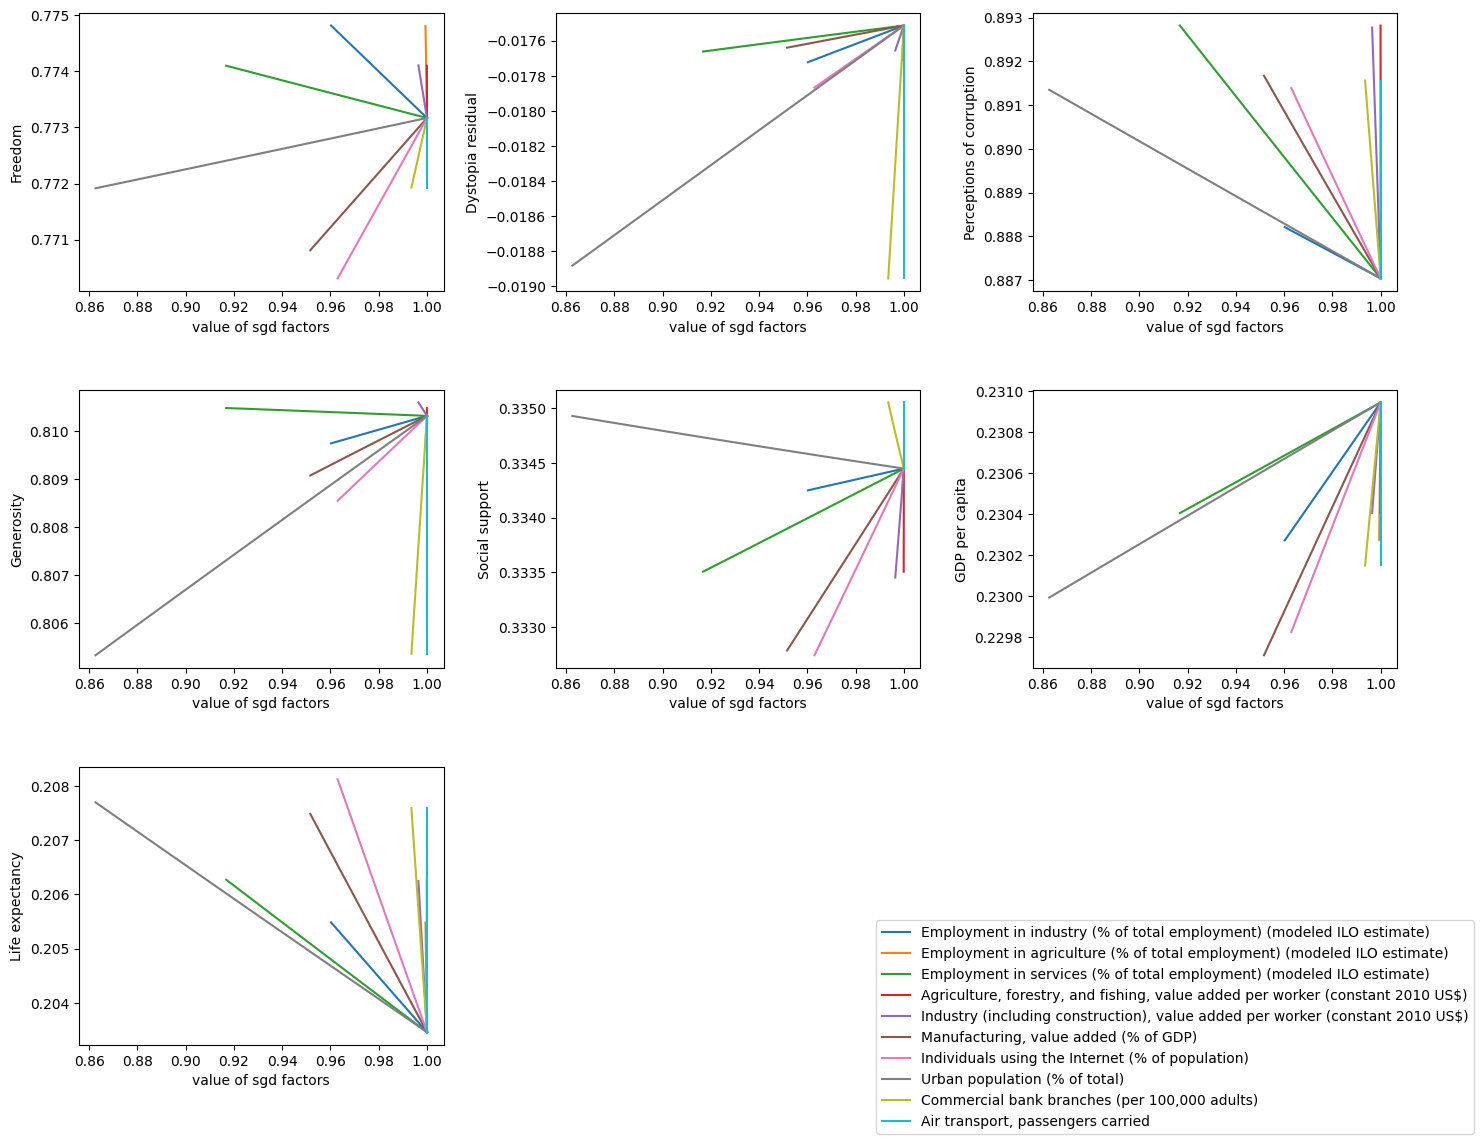

In [204]:
res = one2many(X, Y)
plotDiff(res, X_columns, y_columns, figure_size=(15, 12))

## Happiness Score model

we didn't talk about this model in the presentation, since the world happiness score is calculated by some formula, however, we don't have it. Hence we made a linear regression model to fit it.

you will see the error below, which is very small 6.9e-8, it's totally linear

1. we predict 7 factors in world happiness data by using 10 indicators in sustainable developing goal data
2. we then use those 7 factors to predict happiness score

In [205]:
# produces from preprocessing_all_dataset.ipynb, please run that first if you delete tmp folder
wh_df = pd.read_csv('tmp/wh_all.csv')
wh_df_numeric= wh_df.drop(['Country', 'Country code', 'Year', 'Happiness rank'], axis=1)
wh_df_numeric.head()

,Happiness score,GDP per capita,Social support,Life expectancy,Freedom,Perceptions of corruption,Generosity,Dystopia residual
0,3.575,0.319820,0.302850,0.303350,0.23414,0.097190,0.365100,1.952100
1,3.360,0.382270,0.110370,0.173440,0.16430,0.071120,0.312680,2.145580
2,3.794,0.401477,0.581543,0.180747,0.10618,0.061158,0.311871,2.150801
3,3.632,0.332000,0.537000,0.255000,0.08500,0.036000,0.191000,2.196000
4,3.203,0.350000,0.517000,0.361000,0.00000,0.025000,0.158000,1.792000


In [206]:
from sklearn.preprocessing import PolynomialFeatures
def transform(data):
    X_origin = data.drop('Happiness score', axis=1).to_numpy()
    poly_transformer = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly_transformer.fit_transform(X_origin)
    return X_poly, data['Happiness score'].to_numpy().reshape((-1, 1)), poly_transformer

In [207]:
train, test = train_test_split(wh_df_numeric, test_size=0.1)
X_train, y_train, poly_transformer = transform(train)
# print(X_train.shape)
# print(y_train.shape)

In [208]:
from sklearn.linear_model import LinearRegression

poly_model = LinearRegression()
poly_model.fit(X_train, y_train)

LinearRegression()

In [209]:
X_test, y_test, _ = transform(test)
y_preds = poly_model.predict(X_test)

In [210]:
from sklearn.metrics import mean_squared_error

mae = mean_squared_error(y_test, y_preds)
print(mae)

5.426875251762922e-08


## Urbanization indicators modeling

In [211]:
developed_countries = pd.read_csv(f'./dataset/developed_countries.csv')
developed_countries['Country code'] = get3countryCode(developed_countries['Country'])

In [212]:
sgd = pd.read_csv('./dataset/world_happiness/sustainable_develop_goals/sdg-csv-zip-7-mb-/SDGData.csv')
sgd_urban = sgd[sgd['Indicator Name'].isin(
    URBANIZATION_INDICATORS + ANTI_URBANIZATION_INDICATORS
)].iloc[:, :32].sort_values(by=['Country Name', 'Indicator Name']).reset_index(drop=True)
print(sgd_urban.shape)
sgd_urban

(5260, 32)


,Country Name,Country Code,Indicator Name,Indicator Code,1990,1991,1992,1993,1994,1995,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Afghanistan,AFG,"Agriculture, forestry, and fishing, value adde...",NV.AGR.EMPL.KD,NaN,NaN,NaN,NaN,NaN,NaN,...,587.874492,919.727932,9.150535e+02,8.850408e+02,1.137182e+03,1.084252e+03,1.028653e+03,9.213596e+02,9.308000e+02,9.285927e+02
1,Afghanistan,AFG,"Air transport, freight (million ton-km)",IS.AIR.GOOD.MT.K1,9.400000,8.400000,8.400000,6.700000,12.300000,12.900000,...,NaN,NaN,1.080195e+02,1.094211e+02,1.166607e+02,8.462122e+01,3.428347e+01,3.310204e+01,2.901088e+01,2.514421e+01
2,Afghanistan,AFG,"Air transport, passengers carried",IS.AIR.PSGR,241400.000000,212300.000000,212300.000000,197000.000000,238400.000000,250400.000000,...,NaN,NaN,1.999127e+06,2.279341e+06,1.737962e+06,2.044188e+06,2.209428e+06,1.929907e+06,1.917924e+06,1.858558e+06
3,Afghanistan,AFG,"Annual freshwater withdrawals, agriculture (% ...",ER.H2O.FWAG.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,AFG,"Annual freshwater withdrawals, industry (% of ...",ER.H2O.FWIN.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5255,Zimbabwe,ZWE,"Manufacturing, value added (% of GDP)",NV.IND.MANF.ZS,20.484785,24.096142,26.898699,21.021162,19.054827,19.264222,...,16.334516,11.030513,9.208113e+00,9.172401e+00,1.404340e+01,1.291906e+01,1.259076e+01,1.188860e+01,1.159602e+01,1.101701e+01
5256,Zimbabwe,ZWE,Medium and high-tech industry (% manufacturing...,NV.MNF.TECH.ZS.UN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5257,Zimbabwe,ZWE,"Railways, goods transported (million ton-km)",IS.RRS.GOOD.MT.K6,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5258,Zimbabwe,ZWE,"Railways, passengers carried (million passenge...",IS.RRS.PASG.KM,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [213]:
# control length of the sample
# e.g. 12 is the length of the input time serie, 1 is the output
# for a sequence like 6 valid values like [1, 2, 3, 4, 5, 6] with window size 4
# after processing, there will be 3 samples available for training 
# X1, X2, X3, Y
# [1, 2, 3, 4]
# [2, 3, 4, 5]
# [3, 4, 5, 6]
WINDOW_SIZE = 12 + 1

def nanBeforeTarget(df_tmp):
    # df_tmp = sgd_urban.iloc[0:20, 0:16]
    h, w = df_tmp.shape
    for i in range(h):
        if not pd.isna(df_tmp.iloc[i, w-1]) and pd.isna(df_tmp.iloc[i, w-2]):
            return True
            
def rename_df2merge(df):
    columns = df.columns
    mapping_dict = {}
    for i in range(WINDOW_SIZE-1):
        mapping_dict[columns[i]] = 'x_' + str(i)
    
    mapping_dict[columns[-1]] = 'y'

    df = df.rename(columns=mapping_dict)
    return df

In [214]:
# for the last one, we take it as output of the sequence
valid_dfs = []
for i in range(0, 5260, 20):
    for j in range(0, sgd_urban.shape[1]-4-WINDOW_SIZE):
        df_tmp = sgd_urban.iloc[i:i+20, j+4:j+WINDOW_SIZE+4]
        if nanBeforeTarget(df_tmp):
            continue
            
        valid_dfs.append(df_tmp)


for i in range(len(valid_dfs)):
    valid_dfs[i] = rename_df2merge(valid_dfs[i])

In [215]:
### time series data preparing
row = sgd_urban.iloc[4, :]
def impute_row(row):
    row_numeric = row.iloc[4:].to_numpy()

    row_numeric.shape

    i = 0
    while i < row_numeric.shape[0] and np.isnan(row_numeric[i]):
        row_numeric[i] = 0
        i += 1

    j = i + 1

    while i < row_numeric.shape[0]:
        while i < row_numeric.shape[0] and not np.isnan(row_numeric[i]):
            i += 1

        if i == row_numeric.shape[0]:
            break
        
        j = i
        i -= 1 

        while j < row_numeric.shape[0] and np.isnan(row_numeric[j]):
            j += 1
        
        # means all the values behind index i is null
        if j == row_numeric.shape[0]:
            for index in range(i+1, j):
                row_numeric[index] = row_numeric[i]
        else:
            for index in range(i+1, j):
                row_numeric[index] = row_numeric[i] + (row_numeric[j] - row_numeric[i]) * (index-i) / (j-i)
    
    row.iloc[4:] = row_numeric
    row = row.fillna(0)

    return row

# test impute function, comment out to see the result
# impute_row(row)

In [216]:
sgd_imputed = sgd_urban.apply(impute_row, axis=1)
# impute all the rows, comment out below to see the result
# sgd_imputed

In [217]:
# scaler preparing, becuz we want to normalize in indicators level, so we need to merge all countries indicators values
df_countries = []
h, w = sgd_imputed.shape
for i in range(0, h, 20):
    df_country = sgd_imputed.iloc[i:i+20, 4:].to_numpy()
    df_countries.append(df_country)

sgd_countries = np.concatenate(df_countries, axis=1)
sgd_countries.shape

(20, 7364)

In [218]:
# scaler preparing
from sklearn.preprocessing import StandardScaler
sgd_scaler = StandardScaler()
sgd_scaler.fit(sgd_countries.T)

df_sgd_scaler = sgd_urban.iloc[:20, [2]]
df_sgd_scaler['mean'] = sgd_scaler.mean_
df_sgd_scaler['var'] = sgd_scaler.var_
df_sgd_scaler

,Indicator Name,mean,var
0,"Agriculture, forestry, and fishing, value adde...",9.021116e+03,1.837747e+09
1,"Air transport, freight (million ton-km)",3.673946e+03,2.287826e+08
2,"Air transport, passengers carried",6.201510e+07,5.947968e+16
3,"Annual freshwater withdrawals, agriculture (% ...",2.657374e+01,1.249713e+03
4,"Annual freshwater withdrawals, industry (% of ...",1.008911e+01,4.156090e+02
5,CO2 emissions (metric tons per capita),4.350911e+00,3.686083e+01
6,"Commercial bank branches (per 100,000 adults)",7.305344e+00,2.789444e+02
7,"Educational attainment, competed at least Bach...",1.330029e+00,2.516052e+01
8,"Educational attainment, competed at least Mast...",3.548354e-01,3.909258e+00
9,Employment in agriculture (% of total employme...,2.674475e+01,6.145750e+02


In [219]:
## training data preparing
valid_nps = []
for i in range(len(valid_dfs)):
    df_tmp = valid_dfs[i] 
    df_tmp = df_tmp.apply(impute_row, axis=1)
    np_tmp = df_tmp.to_numpy()
    np_tmp_scaled = sgd_scaler.transform(np_tmp.T).T
    valid_nps.append(np_tmp_scaled)

print(len(valid_nps))
valid_nps[0].shape

sgd_ts_data = np.concatenate(valid_nps)
sgd_ts_data.shape


3085


(61700, 13)

In [220]:
ipnn_indicators = list(sgd_urban.iloc[:20, :]['Indicator Name'])
print(ipnn_indicators)

['Agriculture, forestry, and fishing, value added per worker (constant 2010 US$)', 'Air transport, freight (million ton-km)', 'Air transport, passengers carried', 'Annual freshwater withdrawals, agriculture (% of total freshwater withdrawal)', 'Annual freshwater withdrawals, industry (% of total freshwater withdrawal)', 'CO2 emissions (metric tons per capita)', 'Commercial bank branches (per 100,000 adults)', "Educational attainment, competed at least Bachelor's or equivalent, population 25+, total (%) (cumulative)", "Educational attainment, competed at least Master's or equivalent, population 25+, total (%) (cumulative)", 'Employment in agriculture (% of total employment) (modeled ILO estimate)', 'Employment in industry (% of total employment) (modeled ILO estimate)', 'Employment in services (% of total employment) (modeled ILO estimate)', 'Forest area (% of land area)', 'Individuals using the Internet (% of population)', 'Industry (including construction), value added per worker (con

In [262]:
## Model - encoder and decoder manner
import torch.nn as nn
class IndicatorPredictNN(nn.Module):
    def __init__(self, indicators_dim, hidden_size, rnn_hidden, batch_size, rnn_layers=2) -> None:
        super().__init__()

        self.batch_size = batch_size
        self.rnn_layers = rnn_layers
        self.rnn_hidden = rnn_hidden

        self.linear = nn.Linear(indicators_dim, hidden_size)
        # self.act1 = nn.Sigmoid()
        # self.linear2 = nn.Linear(hidden_size, hidden_size*4)
        # self.act2 = nn.Sigmoid()
        self.rnn = nn.LSTM(hidden_size, rnn_hidden, rnn_layers, batch_first=True)
        # self.act3 = nn.Sigmoid()
        # self.linear4 = nn.Linear(rnn_hidden, hidden_size)
        # self.act4 = nn.Sigmoid()
        self.linear5 = nn.Linear(rnn_hidden, indicators_dim)

    
    def init_hidden(indicators_dim, hidden_dim):
        pass
    
    def forward(self, x):
        out = self.linear(x)
        # out = self.act1(out)
        # out = self.linear2(out)
        # out = self.act2(out)

        h0, c0 = self.init_hidden(self.batch_size, self.rnn_layers, self.rnn_hidden)
        out, _ = self.rnn(out, (h0, c0))

        # out = self.act3(out)
        # out = self.linear4(out[:, -1, :])
        # out = self.act4(out)
        out = self.linear5(out[:, -1, :])
        # out = self.linear5(out)

        return out


    def init_hidden(self, batch_size, rnn_layers, rnn_hidden, bidirection=False, device=torch.device("cuda")):
        h0 = torch.randn((1+bidirection)*rnn_layers, batch_size, rnn_hidden, device=device)
        c0 = torch.randn((1+bidirection)*rnn_layers, batch_size, rnn_hidden, device=device)
        return h0, c0
        
        

In [263]:
indicators_dim = sgd_imputed['Indicator Name'].unique().shape[0]
indicators_dim

20

In [264]:
afg = sgd_imputed.iloc[:20, :]
col = afg.iloc[0:, 4:6].to_numpy(dtype=np.float32)
col
X = torch.Tensor(col).T
X.shape

torch.Size([2, 20])

In [265]:
device = torch.device('cuda')

In [266]:
from sklearn.model_selection import train_test_split

data = sgd_ts_data
samples_len = data.shape[0] // 20
data = data.reshape(samples_len, 20, WINDOW_SIZE)
data = data.transpose((0, 2, 1))

train, test = train_test_split(data, test_size=0.1)

print(train.shape)
print(test.shape)

(2776, 13, 20)
(309, 13, 20)


Epoch: 10/1000............. Loss: 6.8949
Epoch: 20/1000............. Loss: 5.2258
Epoch: 30/1000............. Loss: 4.1128
Epoch: 40/1000............. Loss: 3.2568
Epoch: 50/1000............. Loss: 2.5353
Epoch: 60/1000............. Loss: 2.0271
Epoch: 70/1000............. Loss: 1.5541
Epoch: 80/1000............. Loss: 1.3409
Epoch: 90/1000............. Loss: 1.1697
Epoch: 100/1000............. Loss: 1.0250
Epoch: 110/1000............. Loss: 0.8987
Epoch: 120/1000............. Loss: 0.7808
Epoch: 130/1000............. Loss: 0.7205
Epoch: 140/1000............. Loss: 0.6642
Epoch: 150/1000............. Loss: 0.6547
Epoch: 160/1000............. Loss: 0.5992
Epoch: 170/1000............. Loss: 0.5921
Epoch: 180/1000............. Loss: 0.5878
Epoch: 190/1000............. Loss: 0.5461
Epoch: 200/1000............. Loss: 0.4787
Epoch: 210/1000............. Loss: 0.4689
Epoch: 220/1000............. Loss: 0.4283
Epoch: 230/1000............. Loss: 0.4561
Epoch: 240/1000............. Loss: 0.4225
E

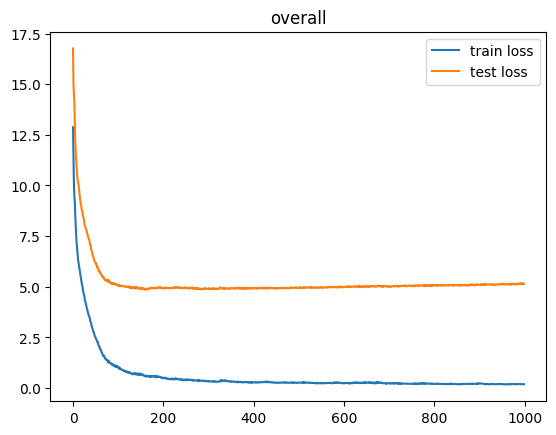

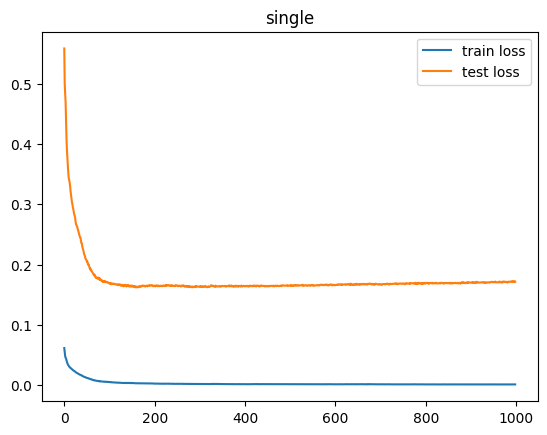

In [267]:
model = IndicatorPredictNN(indicators_dim, indicators_dim*3, indicators_dim*5, 10)
model.to(device)

if not os.path.exists('weights/ipnn.pt'):

    n_epochs = 1000
    lr = 0.01

    # criterion = nn.CrossEntropyLoss()
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train.shape
    X = train[0:10, :WINDOW_SIZE-1, :]
    y = train[0:10, WINDOW_SIZE-1, :]

    losses = []
    test_losses = []
    for epoch in range(1, n_epochs):
        optimizer.zero_grad()
        loss_total = 0

        for i in range(21):
            X = torch.Tensor(train[i*10:(i+1)*10, :WINDOW_SIZE-1, :]).to(device)
            y = torch.Tensor(train[i*10:(i+1)*10, WINDOW_SIZE-1, :]).to(device)

            # print(X.shape)

            out = model(X)
            loss = criterion(out, y)

            loss.backward()

            loss_total += loss.item()
        
        optimizer.step()

        loss_total_test = 0
        for i in range(test.shape[0] // 10):
            start = i*10
            end = (i+1)*10
            if end > test.shape[0]:
                start = end - 10
            
            X_test = torch.Tensor(test[start:end, :WINDOW_SIZE-1, :]).to(device)
            y_test = torch.Tensor(test[start:end, WINDOW_SIZE-1, :]).to(device)

            out = model(X_test)
            loss = criterion(out, y_test)

            loss_total_test += loss.item()


        losses.append(loss_total)
        test_losses.append(loss_total_test)
        
        if epoch%10 == 0:
            print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
            print("Loss: {:.4f}".format(loss_total))


    torch.save(model.state_dict(), 'weights/ipnn.pt')

    ## total loss every 10 epoch
    plt.plot(losses)
    plt.plot(test_losses)
    plt.legend(['train loss', 'test loss'])
    plt.title('overall')
    plt.show()


    ## average loss on each sample
    single_losses = np.array(losses) / 210
    single_test_losses = np.array(test_losses) / (test.shape[0] // 10)

    plt.plot(single_losses)
    plt.plot(single_test_losses)
    plt.legend(['train loss', 'test loss'])
    plt.title('single')

else:
    model.load_state_dict(torch.load('weights/ipnn.pt'))
    model.eval()

ipnn = model

In [268]:
# predict future
## index transform
fpnn_idx_in_ipnn = []
for index_name in fpnn_input_columns:
    fpnn_idx_in_ipnn.append(ipnn_indicators.index(index_name))  
    

print(fpnn_idx_in_ipnn)

[10, 9, 11, 0, 14, 15, 13, 19, 6, 2]


In [269]:
num_countries = 10

nation_numeric = sgd_imputed.iloc[:20*num_countries, 4:].to_numpy()
nation_numeric.shape

for i in range(0, 20*num_countries, 20):
    tmp = nation_numeric[i:i+20, :]
    tmp = sgd_scaler.transform(tmp.T).T
    nation_numeric[i:i+20, :] = tmp

nation_numeric.shape
nation_numeric = nation_numeric.reshape(10, 20, 28)
nation_numeric = nation_numeric.transpose((0, 2, 1))
nation_numeric_tensor = torch.Tensor(nation_numeric).to(device)
nation_numeric_tensor.shape

torch.Size([10, 28, 20])

In [270]:
# predict next year bese on a time series
def onestep(X):
    y = model(X) 
    return y

In [271]:
def getNextNYear(n, X):
    for i in range(n):
        y = model(X).reshape(10, 1, 20)
        X = torch.concat((X, y), 1)
    
    return X[:, -n:, :]

In [272]:
from math import ceil

# how many years want to predict
years = 15

nations_total = sgd_imputed.shape[0] // 20


nextYears = []

for i in range(ceil(nations_total/10)):
    start = i*10*20
    end = (i+1)*10*20

    if end > sgd_imputed.shape[0]:
        end = sgd_imputed.shape[0]
        start = end - 10*20

    nation_numeric = sgd_imputed.iloc[start:end, 4:].to_numpy()

    for j in range(0, end-start, 20):
        tmp = nation_numeric[j:j+20, :]
        tmp = sgd_scaler.transform(tmp.T).T
        nation_numeric[j:j+20, :] = tmp

    nation_numeric = nation_numeric.reshape(10, 20, 28)
    nation_numeric = nation_numeric.transpose([0, 2, 1])

    X = torch.Tensor(nation_numeric).to(device)
    X_next10 = getNextNYear(years, X)

    nextYears.append({
        "start": start,
        "end": end,
        "preds": X_next10.cpu().detach().numpy()
    })
    

In [273]:
# predict future
newCols = []
for i in range(2019, 2019+years):
    newCols.append(str(i))

sgd_preds = sgd_imputed.iloc[:, :4]
sgd_preds = sgd_preds.reindex(columns=list(sgd_preds.columns) + newCols)

for item in nextYears:
    start = item['start']
    end = item['end']
    preds = item['preds']
    preds = preds.transpose([0, 2, 1])
    preds = preds.reshape((end-start), years)
    sgd_preds.iloc[start:end, 4:] = preds

sgd_preds

,Country Name,Country Code,Indicator Name,Indicator Code,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033
0,Afghanistan,AFG,"Agriculture, forestry, and fishing, value adde...",NV.AGR.EMPL.KD,-0.196933,-0.203768,-0.204880,-0.206861,-0.209296,-0.210870,-0.211217,-0.210642,-0.209596,-0.208421,-0.207241,-0.206117,-0.205093,-0.204047,-0.203102
1,Afghanistan,AFG,"Air transport, freight (million ton-km)",IS.AIR.GOOD.MT.K1,-0.212744,-0.209880,-0.212697,-0.214529,-0.216700,-0.219435,-0.221969,-0.223822,-0.224804,-0.224907,-0.224312,-0.223127,-0.221543,-0.219597,-0.217387
2,Afghanistan,AFG,"Air transport, passengers carried",IS.AIR.PSGR,-0.235721,-0.232882,-0.232797,-0.231512,-0.230096,-0.229330,-0.228992,-0.228702,-0.228199,-0.227375,-0.226203,-0.224756,-0.223094,-0.221228,-0.219198
3,Afghanistan,AFG,"Annual freshwater withdrawals, agriculture (% ...",ER.H2O.FWAG.ZS,2.041266,2.080338,2.079957,2.069602,2.055140,2.039433,2.025834,2.015814,2.009001,2.004884,2.002512,2.001197,2.000785,2.000764,2.001454
4,Afghanistan,AFG,"Annual freshwater withdrawals, industry (% of ...",ER.H2O.FWIN.ZS,-0.401699,-0.390426,-0.373496,-0.357276,-0.341242,-0.327392,-0.317680,-0.312090,-0.309835,-0.309945,-0.311536,-0.313997,-0.316910,-0.320040,-0.323095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5255,Zimbabwe,ZWE,"Manufacturing, value added (% of GDP)",NV.IND.MANF.ZS,0.205728,0.178740,0.173114,0.169358,0.166343,0.161960,0.155693,0.147227,0.136642,0.123731,0.108757,0.092125,0.074152,0.055228,0.035780
5256,Zimbabwe,ZWE,Medium and high-tech industry (% manufacturing...,NV.MNF.TECH.ZS.UN,-0.783796,-0.784005,-0.782722,-0.778292,-0.772866,-0.766075,-0.758635,-0.750822,-0.743163,-0.735849,-0.729222,-0.723452,-0.718599,-0.714660,-0.711583
5257,Zimbabwe,ZWE,"Railways, goods transported (million ton-km)",IS.RRS.GOOD.MT.K6,-0.166872,-0.162953,-0.169842,-0.171058,-0.170502,-0.169498,-0.169012,-0.169005,-0.169396,-0.169788,-0.170206,-0.170485,-0.170601,-0.170632,-0.170563
5258,Zimbabwe,ZWE,"Railways, passengers carried (million passenge...",IS.RRS.PASG.KM,-0.153516,-0.139054,-0.133109,-0.128367,-0.125603,-0.123737,-0.122307,-0.121095,-0.119989,-0.119018,-0.118183,-0.117426,-0.116747,-0.116094,-0.115480


In [274]:
# merge preds and old time series
sgd_preds_scaled_back = sgd_preds.iloc[:, :4]
sgd_preds_scaled_back = sgd_preds_scaled_back.reindex(columns=list(sgd_preds_scaled_back.columns) + newCols)
sgd_preds_scaled_back

h, w = sgd_preds.shape
for i in range(0, h, 20):
    tmp = sgd_preds.iloc[i:i+20, 4:]
    tmp = sgd_scaler.inverse_transform(tmp.T).T
    sgd_preds_scaled_back.iloc[i:i+20, 4:] = tmp
    
sgd_preds_and_old = pd.merge(sgd_imputed, sgd_preds_scaled_back, how='inner', on=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'])
sgd_preds_and_old

,Country Name,Country Code,Indicator Name,Indicator Code,1990,1991,1992,1993,1994,1995,...,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033
0,Afghanistan,AFG,"Agriculture, forestry, and fishing, value adde...",NV.AGR.EMPL.KD,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.866692e+01,-3.354451e+01,-8.864577e+00,3.594130e+01,8.633600e+01,1.369083e+02,1.850832e+02,2.290145e+02,2.738287e+02,3.143246e+02
1,Afghanistan,AFG,"Air transport, freight (million ton-km)",IS.AIR.GOOD.MT.K1,9.400000,8.400000,8.400000,6.700000,12.300000,12.900000,...,3.548607e+02,3.165350e+02,2.885147e+02,2.736589e+02,2.721053e+02,2.810960e+02,2.990259e+02,3.229903e+02,3.524127e+02,3.858469e+02
2,Afghanistan,AFG,"Air transport, passengers carried",IS.AIR.PSGR,241400.000000,212300.000000,212300.000000,197000.000000,238400.000000,250400.000000,...,6.085142e+06,6.167445e+06,6.238246e+06,6.360830e+06,6.561944e+06,6.847735e+06,7.200496e+06,7.605829e+06,8.060978e+06,8.556159e+06
3,Afghanistan,AFG,"Annual freshwater withdrawals, agriculture (% ...",ER.H2O.FWAG.ZS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.867031e+01,9.818954e+01,9.783535e+01,9.759450e+01,9.744896e+01,9.736508e+01,9.731862e+01,9.730404e+01,9.730331e+01,9.732770e+01
4,Afghanistan,AFG,"Annual freshwater withdrawals, industry (% of ...",ER.H2O.FWIN.ZS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.414733e+00,3.612731e+00,3.726682e+00,3.772656e+00,3.770409e+00,3.737978e+00,3.687821e+00,3.628436e+00,3.564624e+00,3.502336e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5255,Zimbabwe,ZWE,"Manufacturing, value added (% of GDP)",NV.IND.MANF.ZS,20.484785,24.096142,26.898699,21.021162,19.054827,19.264222,...,1.181011e+01,1.175912e+01,1.169023e+01,1.160410e+01,1.149905e+01,1.137721e+01,1.124187e+01,1.109563e+01,1.094164e+01,1.078339e+01
5256,Zimbabwe,ZWE,Medium and high-tech industry (% manufacturing...,NV.MNF.TECH.ZS.UN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,6.935032e-02,1.922947e-01,3.214133e-01,4.479934e-01,5.688643e-01,6.783887e-01,7.737316e-01,8.539356e-01,9.190411e-01,9.698824e-01
5257,Zimbabwe,ZWE,"Railways, goods transported (million ton-km)",IS.RRS.GOOD.MT.K6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-8.376152e+03,-8.263298e+03,-8.261768e+03,-8.352420e+03,-8.443570e+03,-8.540771e+03,-8.605377e+03,-8.632488e+03,-8.639543e+03,-8.623578e+03
5258,Zimbabwe,ZWE,"Railways, passengers carried (million passenge...",IS.RRS.PASG.KM,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.911709e+02,4.733583e+02,5.429453e+02,6.065152e+02,6.622541e+02,7.102340e+02,7.537487e+02,7.927163e+02,8.302404e+02,8.655274e+02


In [275]:
from math import ceil

def plotIndicators(country):
    sgd_country = sgd_preds_and_old[sgd_preds_and_old['Country Code'] == country]
    sgd_country

    col_per_row = 5

    fig, ax = plt.subplots(ceil(sgd_country.shape[0] / col_per_row), col_per_row)

    fig.set_size_inches(24, 12)
    fig.tight_layout(pad=2.0)

    for i in range(sgd_country.shape[0]):
        index = sgd_country['Indicator Name'].iloc[i]
        indicator_values = sgd_country[sgd_country['Indicator Name'] == index].iloc[:, 4:].to_numpy().reshape(-1, 1)

        old = indicator_values[:27]
        new = indicator_values[27:]
        old_ranges = range(1990, 1990+27)
        new_ranges = range(1990+27, 1990+indicator_values.shape[0])

        row = i // col_per_row
        col = i % col_per_row
        ax[row, col].plot(old_ranges, old)
        ax[row, col].plot(new_ranges, new, color='orange')
        ax[row, col].title.set_text(index[:40])


In [276]:
## available countries to plot
print(sgd_imputed['Country Code'].unique())

['AFG' 'ALB' 'DZA' 'ASM' 'AND' 'AGO' 'ATG' 'ARB' 'ARG' 'ARM' 'ABW' 'AUS'
 'AUT' 'AZE' 'BHS' 'BHR' 'BGD' 'BRB' 'BLR' 'BEL' 'BLZ' 'BEN' 'BMU' 'BTN'
 'BOL' 'BIH' 'BWA' 'BRA' 'VGB' 'BRN' 'BGR' 'BFA' 'BDI' 'CPV' 'KHM' 'CMR'
 'CAN' 'CSS' 'CYM' 'CAF' 'CEB' 'TCD' 'CHI' 'CHL' 'CHN' 'COL' 'COM' 'COD'
 'COG' 'CRI' 'CIV' 'HRV' 'CUB' 'CUW' 'CYP' 'CZE' 'DNK' 'DJI' 'DMA' 'DOM'
 'EAR' 'EAS' 'TEA' 'EAP' 'ECU' 'EGY' 'SLV' 'GNQ' 'ERI' 'EST' 'SWZ' 'ETH'
 'EMU' 'ECS' 'TEC' 'ECA' 'EUU' 'FRO' 'FJI' 'FIN' 'FCS' 'FRA' 'PYF' 'GAB'
 'GMB' 'GEO' 'DEU' 'GHA' 'GIB' 'GRC' 'GRL' 'GRD' 'GUM' 'GTM' 'GIN' 'GNB'
 'GUY' 'HTI' 'HPC' 'HIC' 'HND' 'HKG' 'HUN' 'IBD' 'IBT' 'IDB' 'IDX' 'IDA'
 'ISL' 'IND' 'IDN' 'IRN' 'IRQ' 'IRL' 'IMN' 'ISR' 'ITA' 'JAM' 'JPN' 'JOR'
 'KAZ' 'KEN' 'KIR' 'PRK' 'KOR' 'XKX' 'KWT' 'KGZ' 'LAO' 'LTE' 'LCN' 'TLA'
 'LAC' 'LVA' 'LDC' 'LBN' 'LSO' 'LBR' 'LBY' 'LIE' 'LTU' 'LMY' 'LIC' 'LMC'
 'LUX' 'MAC' 'MDG' 'MWI' 'MYS' 'MDV' 'MLI' 'MLT' 'MHL' 'MRT' 'MUS' 'MEX'
 'FSM' 'MEA' 'TMN' 'MNA' 'MIC' 'MDA' 'MCO' 'MNG' 'M

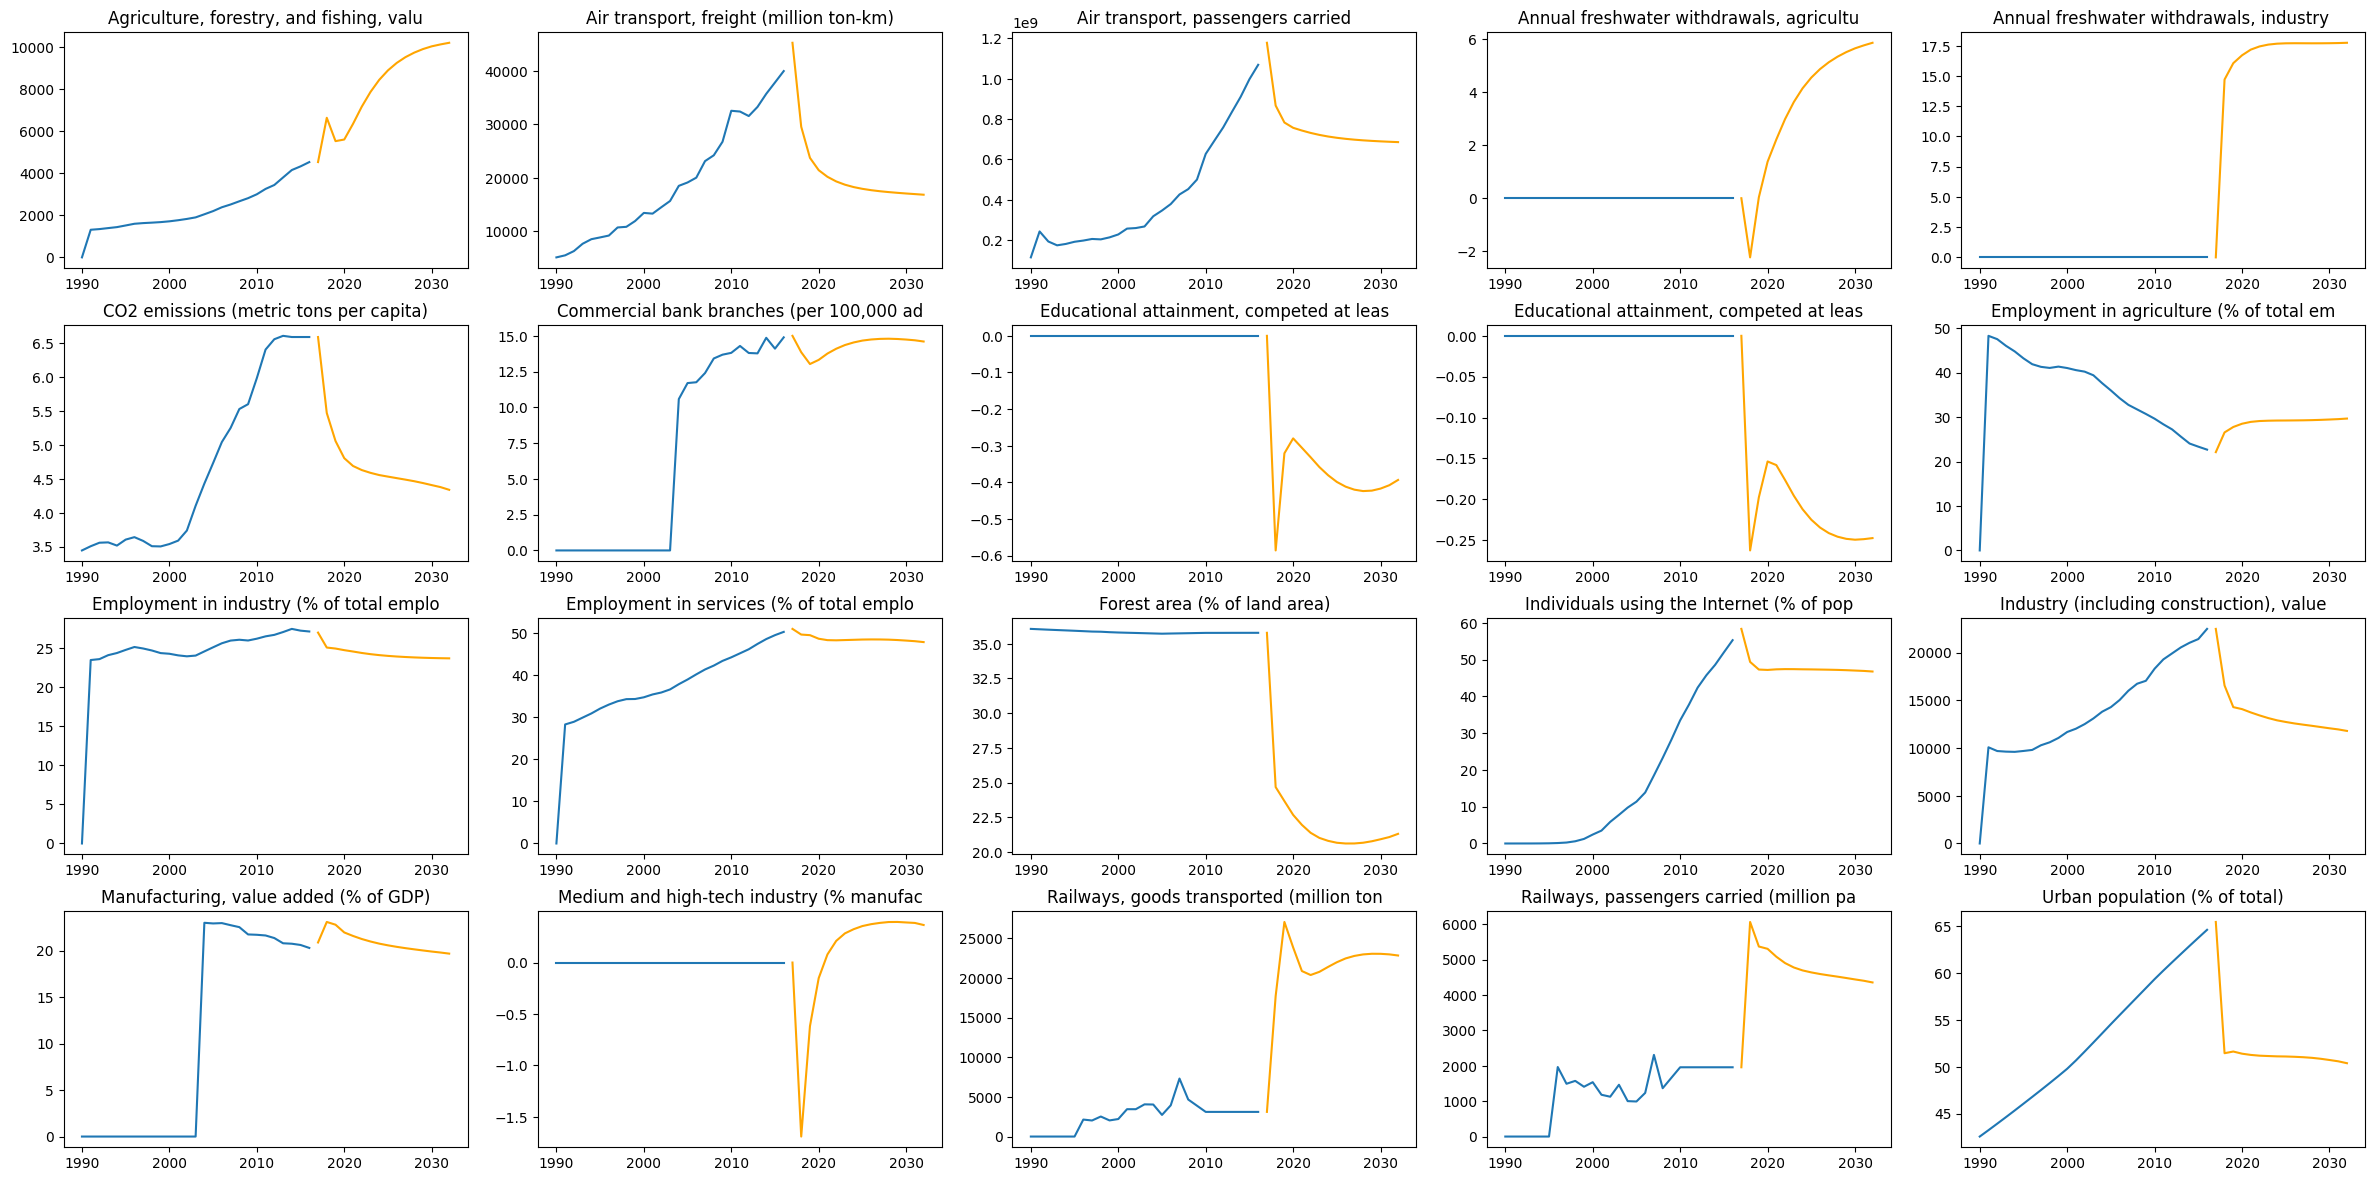

In [277]:
plotIndicators('UMC')

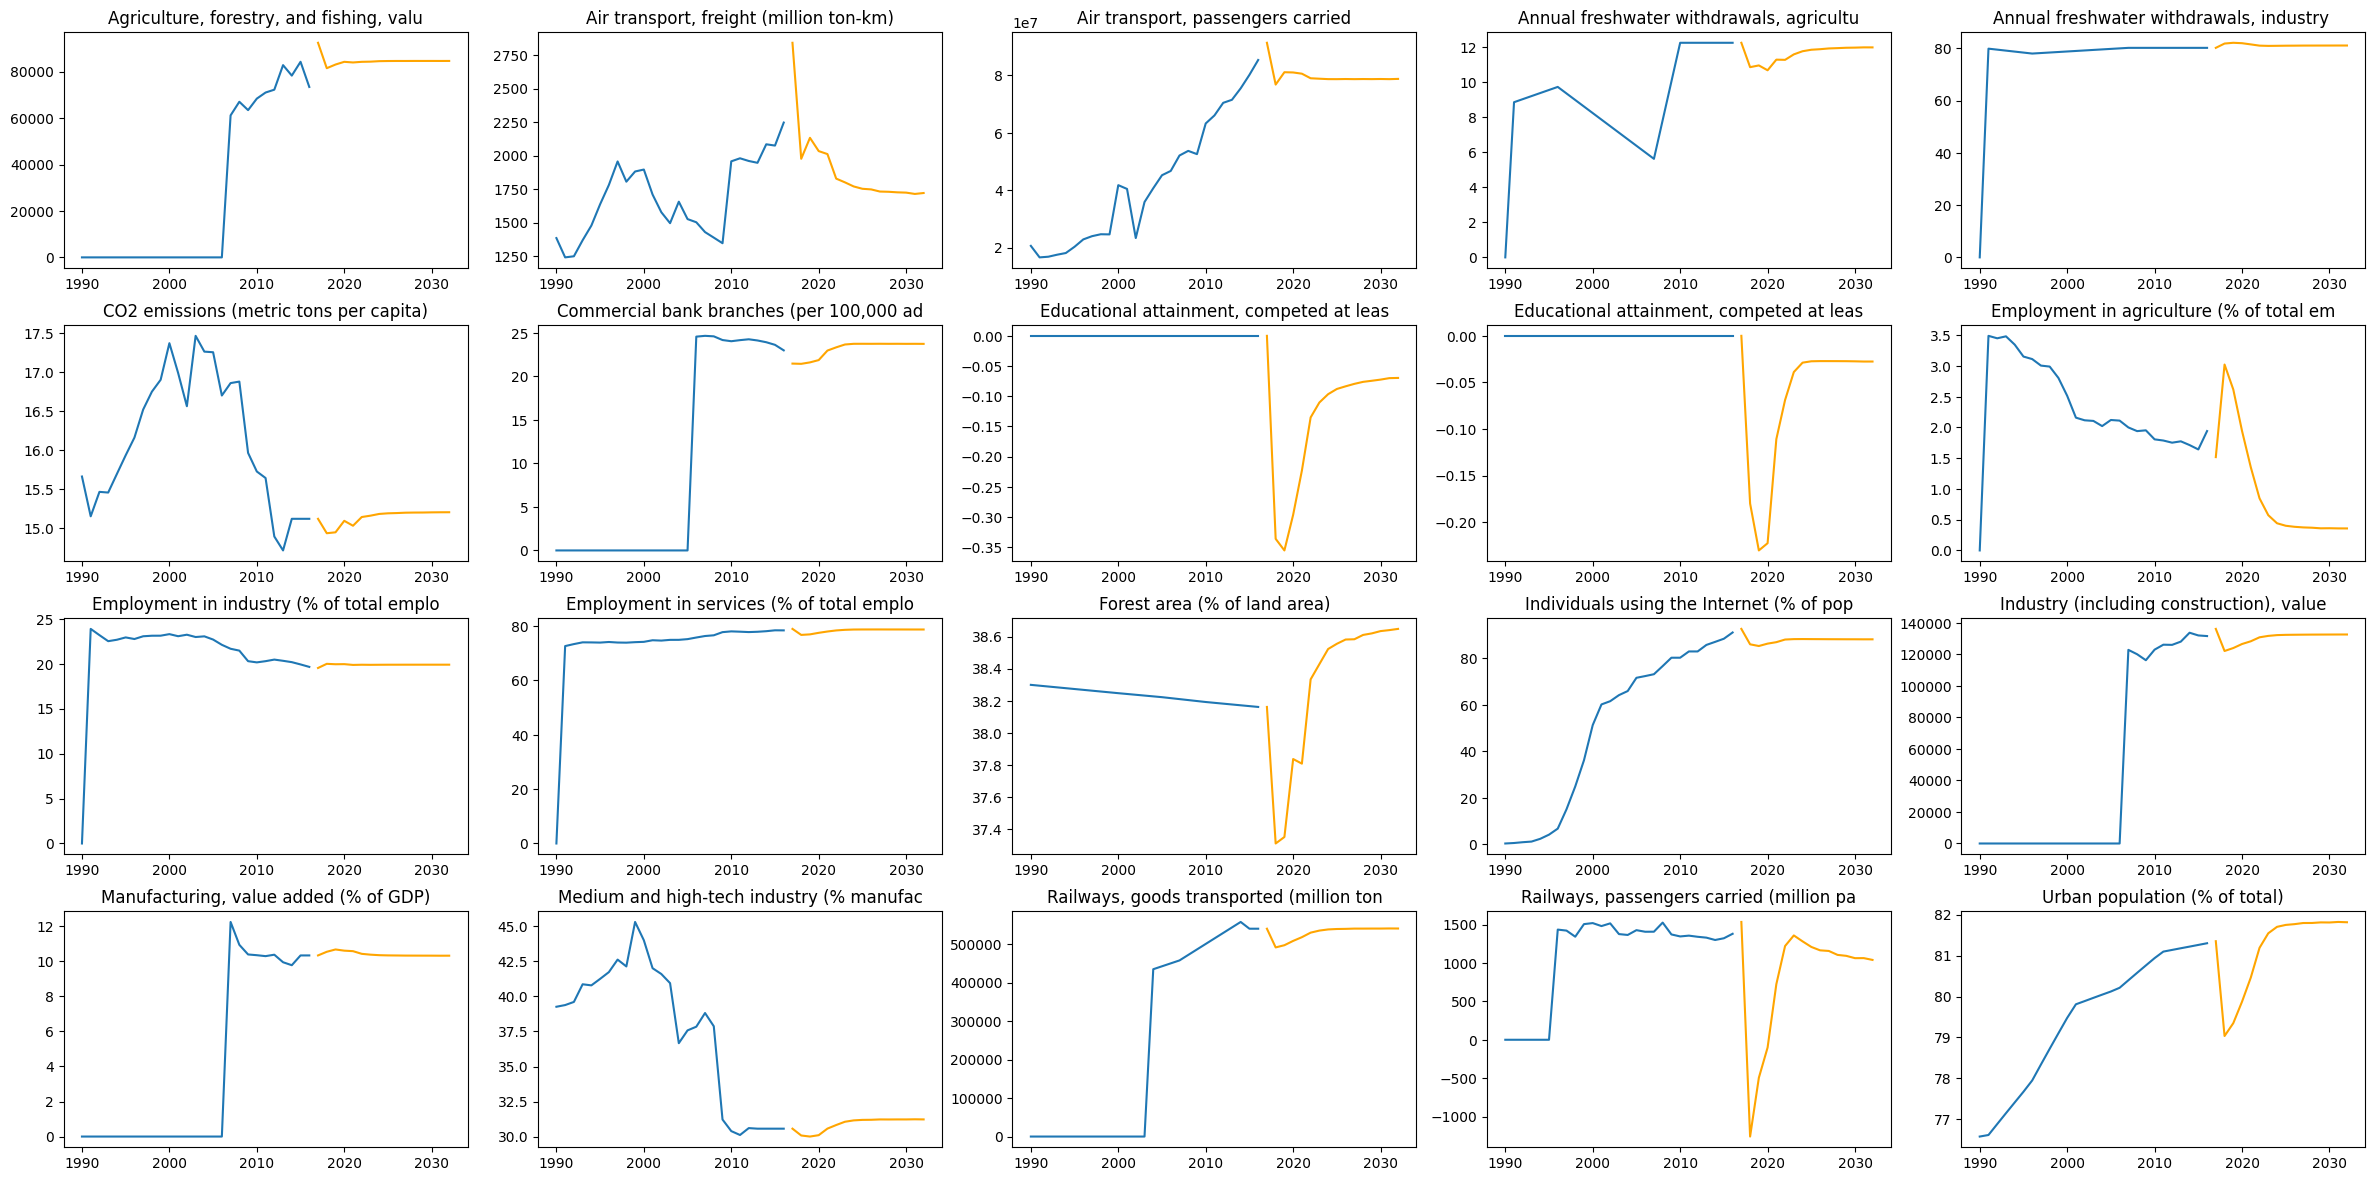

In [278]:
plotIndicators('CAN')

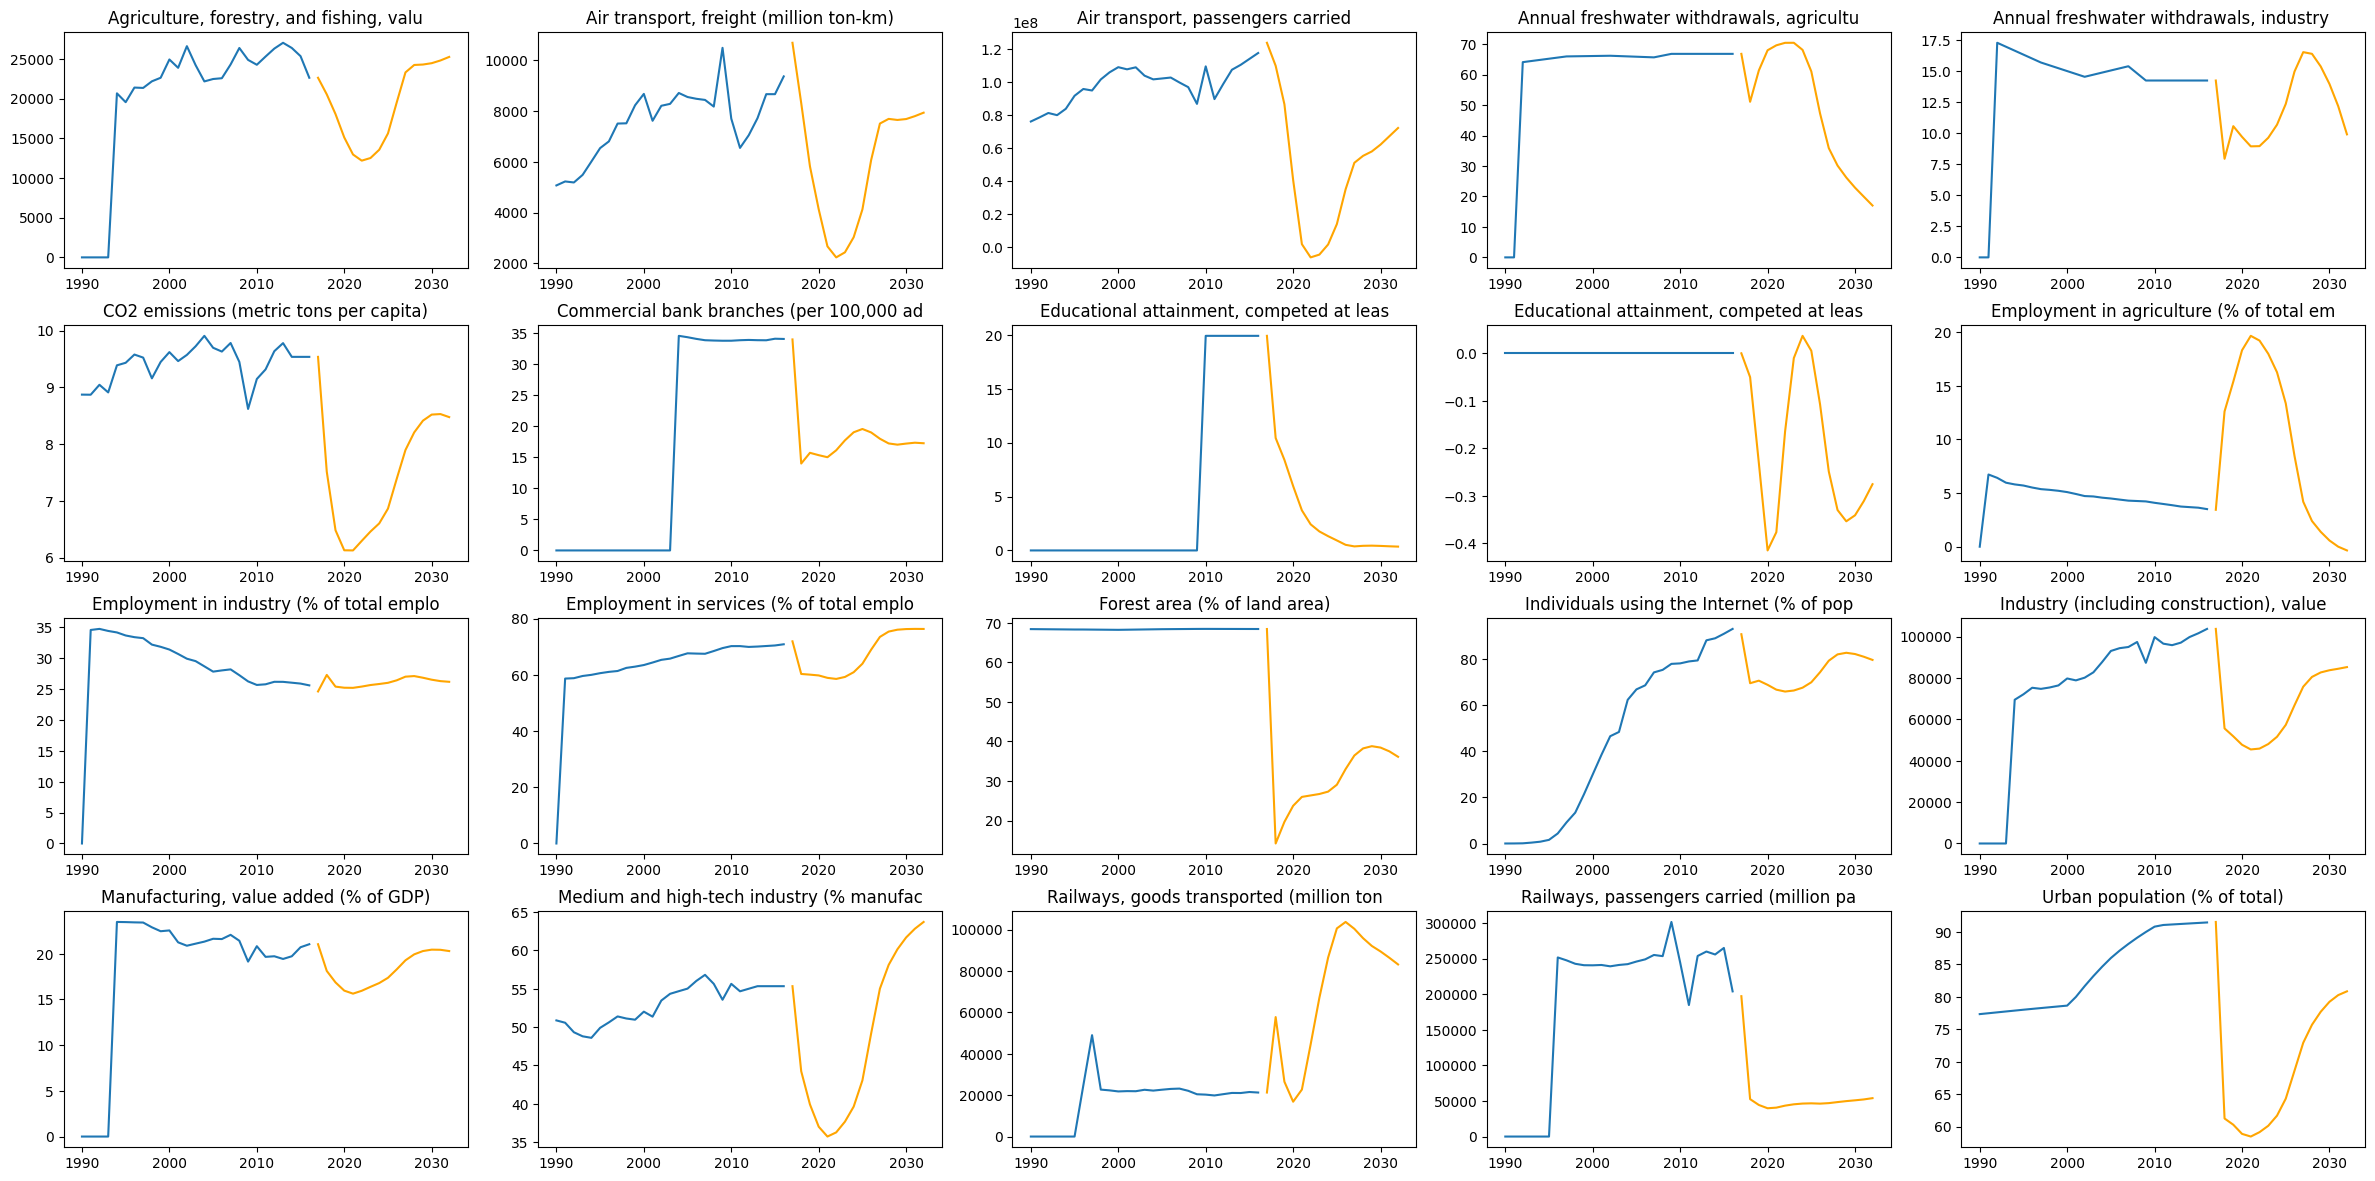

In [279]:
plotIndicators('JPN')

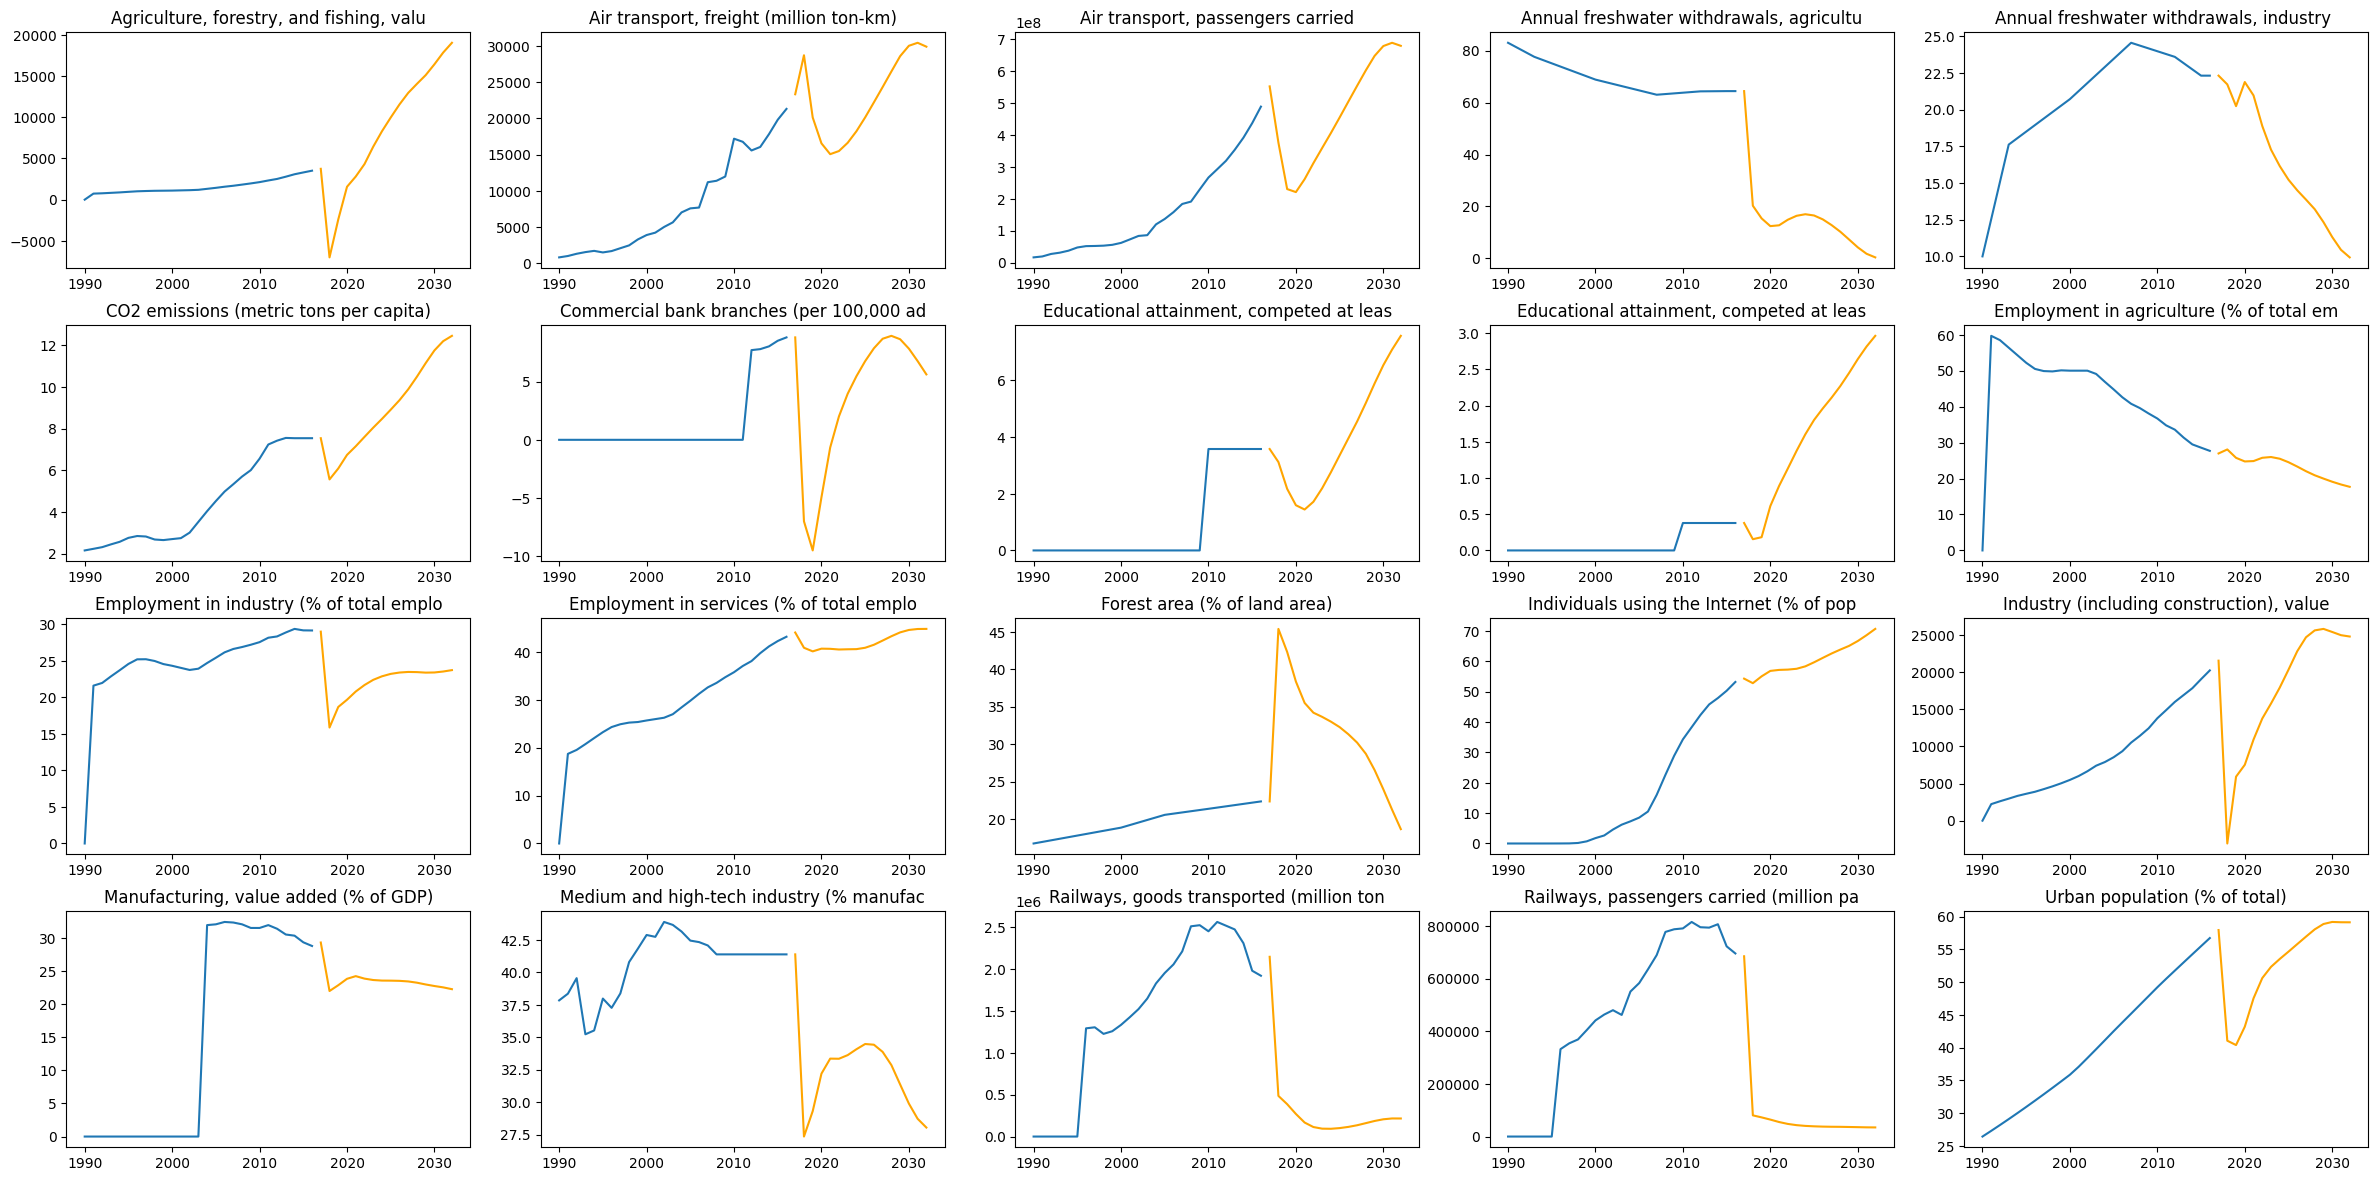

In [280]:
plotIndicators('CHN')

In [281]:
# predict future scores
fpnn_df = sgd_preds_and_old[sgd_preds_and_old['Indicator Name'].isin(fpnn_input_columns)].reset_index(drop=True)

current_order = fpnn_df.iloc[:10, :]['Indicator Name'].to_list()
wanted_order = list(fpnn_input_columns)
current_order
wanted_order

cur2wanted_mapping = []
for idx in wanted_order:
    cur2wanted_mapping.append(current_order.index(idx)) 

print(cur2wanted_mapping)

[4, 3, 5, 0, 7, 8, 6, 9, 2, 1]


In [282]:
def getCountryWHPredictedFeatures(countryCode):
    country_code = countryCode
    country_data = fpnn_df[fpnn_df['Country Code'] == country_code].reset_index(drop=True)
    country_data_reordered = country_data.iloc[cur2wanted_mapping, :]
    idx2iter = country_data_reordered.columns[4:]
    idx2iter

    fpnn_preds = {}

    for idx in list(idx2iter):
        raw = country_data_reordered.loc[:, idx].to_numpy()
        scaled = X_scaler.transform(raw.reshape(1, 10))
        X = torch.Tensor(scaled).to(device)
        y = fpnn(X).cpu().detach().numpy()

        y = Y_scaler.inverse_transform(y)
        fpnn_preds[idx] = y
    
    return fpnn_preds


In [283]:
def getHappinessScore(X):
    X_poly = poly_transformer.transform(X)
    y = poly_model.predict(X_poly)
    return y

In [284]:
wh_df = pd.read_csv('tmp/wh_all.csv')

In [285]:
def plotHappiness(countryCode):
    country = countryCode
    can_wh_preds = getCountryWHPredictedFeatures(country)
    old = wh_df[wh_df['Country code'] == country]['Happiness score'].to_numpy()[:-1]
    
    old_ranges = range(2015, 2019)
    new = []
    new_ranges = [year for year in range(2019, 2034)]
        
    for idx in new_ranges:
        new.append(getHappinessScore(can_wh_preds[str(idx)])[0][0]) 
    

    if len(old) > 0: 
        new_ranges.insert(0, 2018)
        new.insert(0, old[-1])


    # whc = np.array(whc)
    # print(whc.shape)
    # print(whc_old.shape)

    # whc2plot = np.concatenate((whc_old, whc))
    # x = [str(year) for year in range(2015, 2015 + len(whc2plot))]


    plt.figure(figsize=(12, 6))
    if len(old) > 0: plt.plot(old_ranges,old)
    plt.plot(new_ranges, new, color='orange')
    plt.xlabel('date')
    plt.ylabel('happiness score')
    plt.title(f'{country} happiness scores')

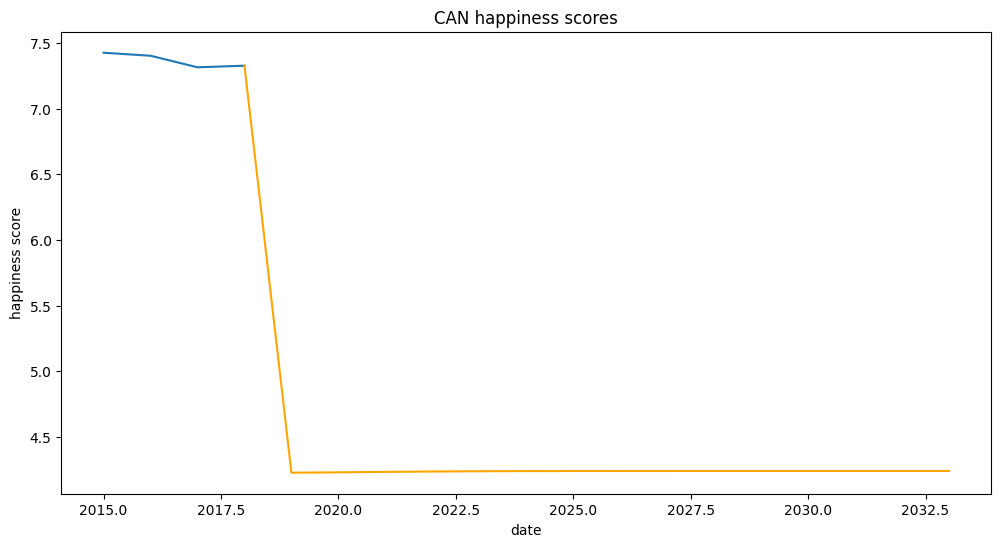

In [286]:
plotHappiness('CAN')

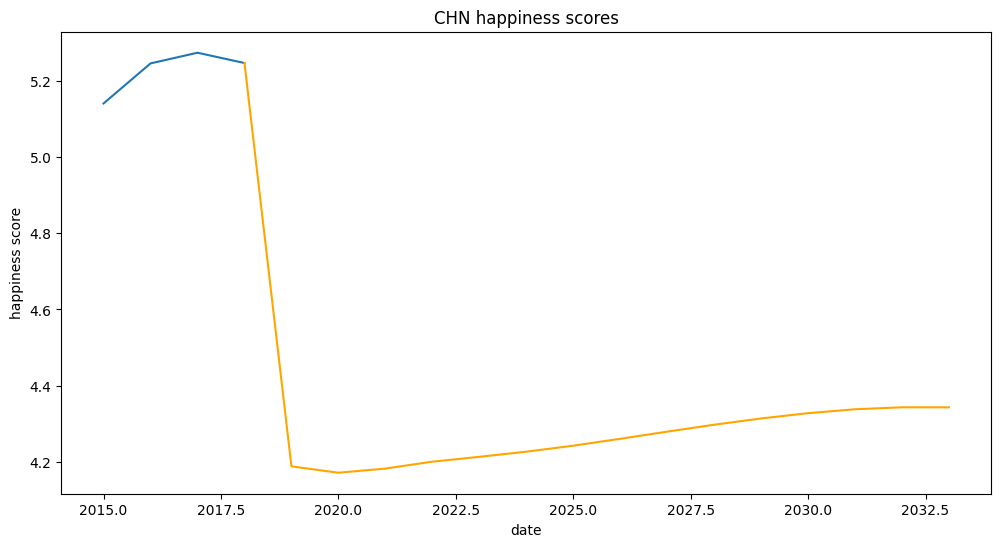

In [287]:
plotHappiness('CHN')

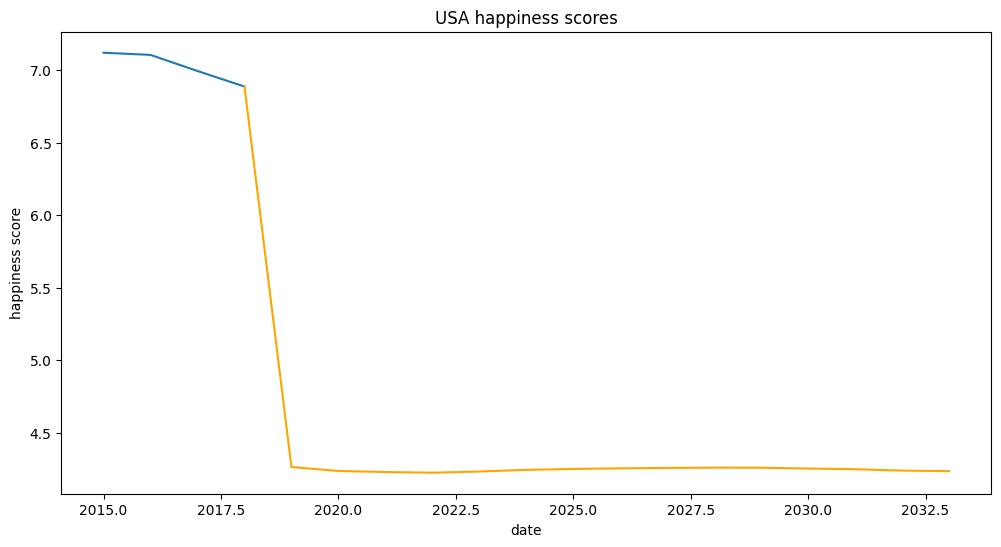

In [288]:
plotHappiness('USA')

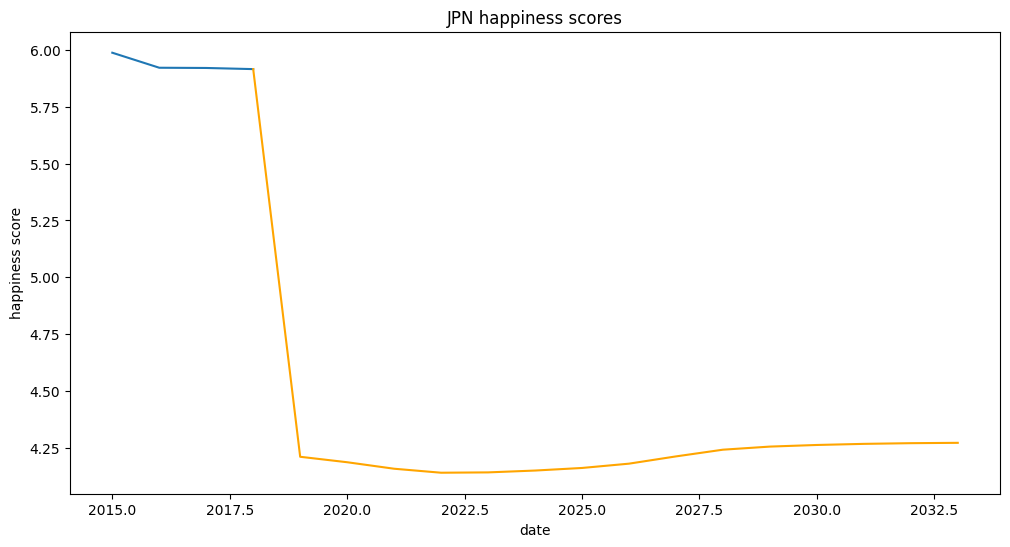

In [289]:
plotHappiness('JPN')